# Machine Learning II: Assignments 2
Leon Berghoff, Jiawei Li, Strahinja Trenkic, Otto Riess

In [8]:
import numpy as np
import pandas as pd
from bank_mkt import import_dataset, split_dataset, transform, evaluate, search
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.utils.fixes import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titlesize": "large",
      "axes.titleweight": "bold",
      "axes.titlepad": 12,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

# Data Preparation

The bank marketing dataset was collected by Moro, Cortez, and Rita (2014) with marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be or not subscribed. The data is ordered by date ranging from May 2008 to November 2010.

In [9]:
bank_mkt = import_dataset("BankMarketing.csv")

In [10]:

func_transformer = FunctionTransformer(transform)

num_features = ["month",
                "day_of_week",
                "campaign",
                "previous",
                "emp.var.rate",
                "cons.price.idx",
                "cons.conf.idx",
                "euribor3m",
                "nr.employed"]

standard_scaler = ColumnTransformer([("scaler", StandardScaler(), num_features)], remainder="passthrough")

preprocessor = make_pipeline(func_transformer, standard_scaler)

X_train, y_train, X_test, y_test, *_ = split_dataset(bank_mkt, preprocessor, test_size=0.3)

# Metrics

The dataset is clearly imbalanced where positive results are far less than negative results. Banks want to improve both recall and precision rates for marketing compains while the true negative rate is not as important.

In [11]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([7136, 2309]))

A receiver operating characteristic (ROC) is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting TPR against FPR at various threshold settings. Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. Both metrics work well with imbalaced dataset while AP sets higher weights for true positives.

$$
AP = \sum_{n} (REC_n - REC_{n-1})PRE_n
$$

Our goal is to maximize the area under ROC and AP curve.

In [12]:
names = ["Constant Prediction",
         "Random Prediction",
         "K-Nearest Neighbors",
         "Linear SVM",
         "Decision Tree",
         "Logistic Regression"]

clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        KNeighborsClassifier(n_neighbors=10),
        SGDClassifier(loss="hinge", class_weight="balanced"),
        DecisionTreeClassifier(max_depth=5, class_weight="balanced"),
        LogisticRegression(class_weight="balanced")]

n = len(names)

y_pred = {}
for name, clf in zip(names, clfs):
    y_pred[name] = cross_val_predict(clf, X_train, y_train, cv=5, n_jobs=-1)

y_score = {}

y_threshold = {}

for name, clf in zip(names, clfs):
    if hasattr(clf, "decision_function"):
        response_method = "decision_function"
    else:
        response_method = "predict_proba"
        
    y_score[name] = cross_val_predict(clf,
                                      X_train,
                                      y_train,
                                      cv=5,
                                      n_jobs=-1,
                                      method=response_method)
    
    if name == "Logistic Regression":
        # For logistic regression, the hyperplane refered in the decision function is b_0+b_1x_1+...b_kx_k.
        # When hyperplane is 0, the probablity is 0.5,
        # therefore the threshold of decision function for logistic regression is 0.
        # https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun
        y_threshold[name] = 0
    elif name == "Linear SVM":
        y_threshold[name] = 0
    else:
        y_score[name] = y_score[name][:, 1]
        y_threshold[name] = 0.5

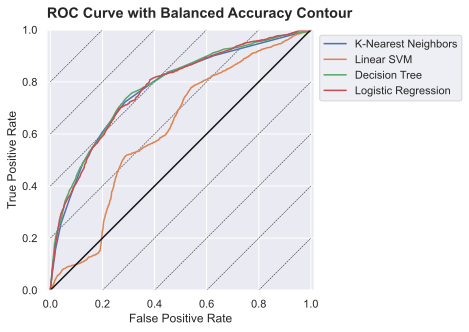

In [13]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def bacc(x, y):
    return (1-x+y)/2

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X, Y = np.meshgrid(x, y)
Z = bacc(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    fpr, tpr, thresholds = roc_curve(y_train, y_score[name])
    ax.plot(fpr, tpr, label=name)
    
ax.plot([0, 1], [0, 1], color="k")
ax.axis("equal")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel="False Positive Rate",
       ylabel="True Positive Rate",
       title="ROC Curve with Balanced Accuracy Contour");

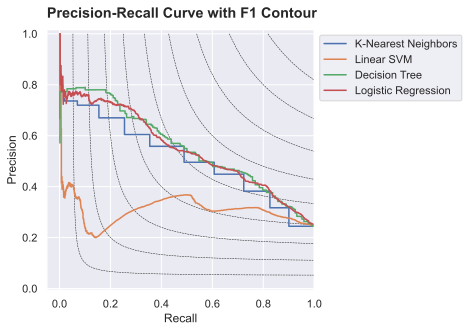

In [14]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

def f1(x, y):
    return 2*x*y/(x+y)

x = np.linspace(0.01,1)
y = np.linspace(0.01,1)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.contour(X, Y, Z, levels=10, linewidths=0.5, linestyles="dashed", colors="k")

for name in names[2:]:
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score[name])
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    ax.plot(recalls, precisions, drawstyle="steps-post", label=name)

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("equal")
ax_legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax_set = ax.set(xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve with F1 Contour")

# SVM

## Polynomial Kernel

The polinomial kernel is 

$$
K(x_i,x_j) = ( r + \gamma x_i^T x_j)^d
$$

where $d$ is degree of the polinomial kernel, $r$ is a constant and $\gamma$ is scaler.

Because kernel values usually depend on the inner products of feature vectors, e.g. the linear kernel and the polynomial kernel, large attribute values might cause numerical problems. The point being that unlike other conventional kernels the polinomial kernel rises exponentially with $d$. 

According to the research performed by Li-Chia Yeh and Chung-Chin Lu from Department of Electrical Engineering, National Tsing Hua University, Hsinchu, Taiwan that we used as a reference the relationship between the error rate and these hyperpameters is as follows. Each curve represents a value of $d$:

![](https://i.ibb.co/MD39sTS/Polin.jpg)

Usually the parameter $r$ is set to zero and $\gamma$ to a fixed value, e.g. 1/n with n being the number of observations. Beside the cost parameter $C$ the integer parameter $d$ has to be tuned, usually values between 1 and 10 are chosen.

In [15]:
poly_svm = SVC(kernel="poly", class_weight="balanced", max_iter=1e6, random_state=42)

poly_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    "degree": range(2, 10),
    }

search(X_train, y_train, X_test, y_test, poly_svm, poly_distributions, scoring="average_precision")

best parameters found: {'C': 2.293391875247842, 'degree': 2, 'gamma': 0.0014534837878339057}, with mean test score: 0.4291571993320091.


,Train,Test
TNR,0.802971,0.791694
TPR,0.578605,0.582828
REC,0.578605,0.582828
PRE,0.487236,0.475288
bACC,0.690788,0.687261
ROC,0.738044,0.730839
AP,0.430390,0.421371


In [16]:
poly_svm = SVC(kernel="poly", class_weight="balanced", max_iter=1e6, random_state=42)

poly_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    "degree": range(2, 10),
    }

search(X_train, y_train, X_test, y_test, poly_svm, poly_distributions, scoring="roc_auc")

best parameters found: {'C': 2.5753950970926462, 'degree': 2, 'gamma': 0.035807157023328}, with mean test score: 0.7371118780313584.


,Train,Test
TNR,0.825112,0.810661
TPR,0.546557,0.543434
REC,0.546557,0.543434
PRE,0.502789,0.481647
bACC,0.685835,0.677047
ROC,0.730716,0.723894
AP,0.430910,0.414050


We can see that optimizing for AP and ROC reaches to similiar results. The search using AP achieved better ROC and AP on the test set.

## Gaussian Kernels

The radial kernel function reads

<img src="https://miro.medium.com/max/265/1*ZMCGXM4ROxEXlNe0SUlToA.jpeg" alt="Polin" border="0"></a>

where $\sigma$ is variance and our hyperparameter. The radial kernel is one of the most popular kernels. RBFs are able to avoid problems of space complexity, as they do not have to store the full dataset during training, but just the support vectors.

Given this simple kernel function, sci-kit learn RBF models only come with the SVM-wide cost hyperparameter C, as well as γ, which is inversely proportional  to  σ. Intuitively, the gamma parameter is the inverse of the radius of influence of support vectors. A large gamma thus increases the risk of overfitting. The cost hyperparameter essentially controls how much cost incurs for a misclassification for a given curve.

In [22]:
rbf_svm = SVC(kernel="rbf", class_weight="balanced", max_iter=1e6, random_state=42)

rbf_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    }

search(X_train, y_train, X_test, y_test, poly_svm, rbf_distributions, scoring="average_precision")

best parameters found: {'C': 4.903150812999551, 'gamma': 0.010006853928548153}, with mean test score: 0.4326857368488058.


,Train,Test
TNR,0.829176,0.816874
TPR,0.450411,0.456566
REC,0.450411,0.456566
PRE,0.460381,0.446640
bACC,0.639794,0.636720
ROC,0.739672,0.727563
AP,0.430883,0.417603


In [23]:
rbf_svm = SVC(kernel="rbf", class_weight="balanced", max_iter=1e6, random_state=42)

rbf_distributions = {
    "C": loguniform(1, 1e2),
    "gamma": loguniform(0.001, 1),
    }

search(X_train, y_train, X_test, y_test, poly_svm, rbf_distributions, scoring="roc_auc")

best parameters found: {'C': 72.99263172753352, 'gamma': 0.17275793870167105}, with mean test score: 0.7356370926807821.


,Train,Test
TNR,0.847113,0.842054
TPR,0.412733,0.417172
REC,0.412733,0.417172
PRE,0.466243,0.460938
bACC,0.629923,0.629613
ROC,0.748661,0.739610
AP,0.432562,0.418209


RBF kernel searching using ROC reaches the best result on test set. However, the improvement of using RBF kernel over polynomial kernel is very minimal.